# Comparação de Modelos: CNN vs. LSTM 🥊

Neste notebook, treinamos as duas arquiteturas com os mesmos dados e hiperparâmetros para comparar o desempenho.

In [1]:
# Importações do projeto
import sys
import os

# 1. Configurar Caminhos (para importar do diretório pai)
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import seaborn as sns
from sklearn.calibration import calibration_curve
import pandas as pd
import torch
from torch.utils.data import DataLoader
import numpy as np
from train_optuna import get_data
from models.models_optuna import CharCNN, CharLSTM
from utils.utils import VOCAB_SIZE
import glob

/home/gabriel/projects/URLifeguard/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando dispositivo: cuda


In [2]:
# --- Reconstrói o modelo a partir do CSV do Optuna ---
def load_best_model_from_csv(csv_path, model_path, model_type, num_classes, device):
    if not os.path.exists(csv_path) or not os.path.exists(model_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {csv_path} ou {model_path}")

    # Ler CSV e pegar a linha com o melhor 'value' (F1 Score)
    df = pd.read_csv(csv_path)
    best_row = df.loc[df['value'].idxmax()]
    
    if model_type == "CNN":
        # Reconstruir a lista de filtros dinamicamente
        n_layers = int(best_row['params_n_conv_layers'].item())
        filters_list = [int(best_row[f'params_n_filter_l{i}'].item()) for i in range(n_layers)]
        
        model = CharCNN(
            vocab_size=VOCAB_SIZE,
            embed_dim=int(best_row['params_embed_dim'].item()),
            n_filters=filters_list,
            kernel_sizes=int(best_row['params_kernel_sizes'].item()),
            fc_dim=int(best_row['params_fc_dim'].item()),
            dropout=float(best_row['params_dropout'].item()),
            num_classes=num_classes
        )
        
    elif model_type == "LSTM":
        model = CharLSTM(
            vocab_size=VOCAB_SIZE,
            embed_dim=int(best_row['params_embed_dim'].item()),
            hidden_dim=int(best_row['params_hidden_dim'].item()),
            n_layers=int(best_row['params_n_layers'].item()),
            dropout=float(best_row['params_dropout'].item()),
            num_classes=num_classes
        )

    else:
        return

    # Carregar pesos
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo {model_type} carregado! (Melhor F1 no CSV: {best_row['value']:.4f})")
    return model


In [19]:
# 5. Gerar Predições (y_pred e y_probs)
def get_preds(model, dataset, device) -> tuple[np.ndarray, np.ndarray]:
    if model is None: return np.ndarray(0), np.ndarray(0)
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    probs_list = []
    preds_list = []
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Probabilidades
            probs = torch.nn.functional.softmax(outputs, dim=1)
            probs_list.extend(probs.cpu().numpy())
            
            # Classe Predita
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            
    return np.array(preds_list), np.array(probs_list)


In [31]:
# 6. Carregar Histórico do CSV
def load_history_from_csv(model_type, model_version=0):
    # Define o diretório onde os resultados estão (pasta 'results' no diretório pai)
    results_dir = os.path.join(parent_dir, "results")
    
    file_pattern = f"urlifeguard_FINAL_{model_type.lower()}_{model_version}_history.csv"
    search_path = os.path.join(results_dir, file_pattern)
    
    # Encontrar arquivos que batem com o padrão
    files = glob.glob(search_path)
    
    if not files:
        raise FileNotFoundError(f"AVISO: Nenhum histórico encontrado para {model_type} em {results_dir}")
    
    # Pega o arquivo mais recente (caso tenha treinado várias vezes)
    latest_file = max(files, key=os.path.getctime)
    print(f"Carregando histórico {model_type}: {os.path.basename(latest_file)}")
    
    # Lê o CSV e retorna como DataFrame
    return pd.read_csv(latest_file)


In [6]:
VERSION = 100

# 2. Configurações Básicas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Caminhos dos arquivos
PATH_DATA = os.path.join(parent_dir, "data", "malicious_phish.csv")
PATH_CSV_CNN = os.path.join(parent_dir, "results", f"optuna_results_cnn_{VERSION}.csv")
PATH_CSV_LSTM = os.path.join(parent_dir, "results", f"optuna_results_lstm_{VERSION}.csv")


Usando dispositivo: cuda


In [11]:
import shutil
from train_optuna import InfoConfig


info = InfoConfig(
    N_TRIALS=50, 
    MODEL_VERSION=100, 
    MODEL_TYPES=["CNN", "LSTM"], 
    DATASET_PATH="../data/malicious_phish.csv", 
    LEARNING_RATE=[1e-6, 1e-3], 
    BATCH_SIZE=[32, 64, 128, 256], 
    OPTIMIZER_NAME=["Adam", "SGD", "RMSprop"], 
    EPOCHS=50, 
    EMBED_DIM=[16, 32], 
    DROPOUT=[0.4, 0.6], 
    PATIENCE=10, 
    WEIGHT_DECAY=[1e-4, 1e-3],
    HIDDEN_DIM_LSTM=[16, 32], 
    N_LAYERS_LSTM=[1], 
    N_CONV_LAYERS_CNN=[1], 
    KERNEL_SIZES_CNN=[2, 3], 
    FC_DIM_CNN=[16, 32], 
    FILTER_SIZES_CNN=[16, 32], 
    NR_SAMPLE=None, 
    TEST_SIZE=0.45,
    DB_NAME='db.sqlite',
    SCREEN_WIDTH=shutil.get_terminal_size(fallback=(80, 24)).columns
    )

In [12]:
# 3. Carregar Dados (Garante o mesmo split de teste do treino)
_, test_dataset, num_classes, _ = get_data(info)

# Definir y_test (Target Verdadeiro)
y_test = test_dataset.y.numpy()



============================== Carregando dataset ==============================

Classes mapeadas (4): {'phishing': 0, 'benign': 1, 'defacement': 2, 'malware': 3}
Pré-processando dados para a RAM (Isso pode levar alguns segundos)...


Tokenizando URLs: 100%|██████████| 352615/352615 [02:23<00:00, 2451.42it/s]


Pré-processando dados para a RAM (Isso pode levar alguns segundos)...


Tokenizando URLs: 100%|██████████| 288504/288504 [01:53<00:00, 2546.07it/s]


In [29]:
# 7. Definir History
print("\n--- Carregando Históricos de Treinamento ---")
history_cnn = load_history_from_csv("CNN", VERSION)
history_lstm = load_history_from_csv("LSTM", VERSION)
if history_cnn is not None:
    print(f"CNN History: {len(history_cnn)} épocas carregadas.")
if history_lstm is not None:
    print(f"LSTM History: {len(history_lstm)} épocas carregadas.")



--- Carregando Históricos de Treinamento ---
Carregando histórico CNN: urlifeguard_FINAL_cnn_100_history.csv
Carregando histórico LSTM: urlifeguard_FINAL_lstm_100_history.csv
CNN History: 39 épocas carregadas.
LSTM History: 39 épocas carregadas.


In [16]:
PATH_MODEL_CNN = os.path.join(parent_dir, "checkpoints", f"urlifeguard_FINAL_cnn_{VERSION}.pth")
PATH_MODEL_LSTM = os.path.join(parent_dir, "checkpoints", f"urlifeguard_FINAL_lstm_{VERSION}.pth")

# 4. Carregar os Modelos
print("Carregando CNN...")
model_cnn = load_best_model_from_csv(PATH_CSV_CNN, PATH_MODEL_CNN, "CNN", num_classes, device)

print("Carregando LSTM...")
model_lstm = load_best_model_from_csv(PATH_CSV_LSTM, PATH_MODEL_LSTM, "LSTM", num_classes, device)

print("Gerando inferências...")
y_pred_cnn, y_probs_cnn = get_preds(model_cnn, test_dataset, device)
y_pred_lstm, y_probs_lstm = get_preds(model_lstm, test_dataset, device)

print("\n--- Variáveis Definidas com Sucesso ---")

Carregando CNN...
Modelo CNN carregado! (Melhor F1 no CSV: 0.9592)
Carregando LSTM...
Modelo LSTM carregado! (Melhor F1 no CSV: 0.8078)
Gerando inferências...

--- Variáveis Definidas com Sucesso ---


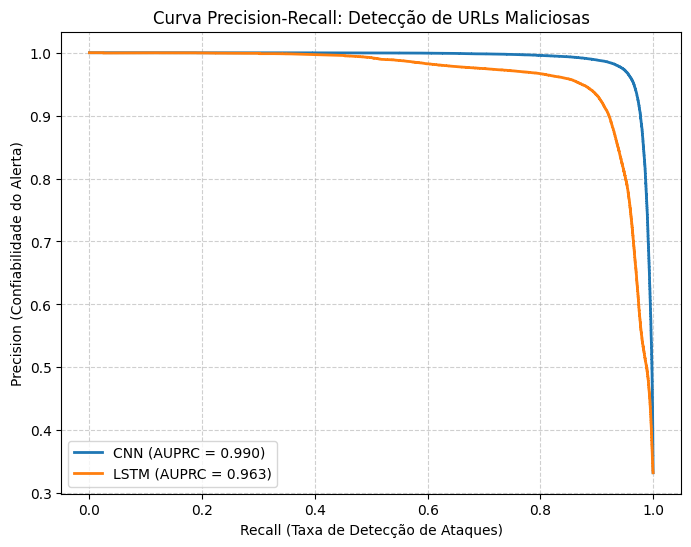

In [24]:
# 1. Identificar o índice da classe "Benign"
BENIGN_IDX = 1

# 2. Binarizar os Rótulos Reais (y_test)
# Se for Benigno (1) vira 0 (Negativo). Se for qualquer outra coisa, vira 1 (Positivo/Ataque).
y_test_binary = (y_test != BENIGN_IDX).astype(int)

# 3. Binarizar as Probabilidades (y_probs)
# A probabilidade de ser "Malicioso" é a soma das probabilidades de não ser benigno.
# Matematicamente: P(Malicioso) = 1.0 - P(Benigno)
# y_probs_cnn[:, BENIGN_IDX] pega apenas a coluna de probabilidade da classe benigna.
y_probs_cnn_binary = 1.0 - y_probs_cnn[:, BENIGN_IDX]
y_probs_lstm_binary = 1.0 - y_probs_lstm[:, BENIGN_IDX]

# 4. Calcular as curvas (com dados binários)
precision_cnn, recall_cnn, _ = precision_recall_curve(y_test_binary, y_probs_cnn_binary)
auc_cnn = auc(recall_cnn, precision_cnn)

precision_lstm, recall_lstm, _ = precision_recall_curve(y_test_binary, y_probs_lstm_binary)
auc_lstm = auc(recall_lstm, precision_lstm)

# 5. Plotar
plt.figure(figsize=(8, 6))
plt.plot(recall_cnn, precision_cnn, label=f'CNN (AUPRC = {auc_cnn:.3f})', linewidth=2)
plt.plot(recall_lstm, precision_lstm, label=f'LSTM (AUPRC = {auc_lstm:.3f})', linewidth=2)

plt.xlabel('Recall (Taxa de Detecção de Ataques)')
plt.ylabel('Precision (Confiabilidade do Alerta)')
plt.title('Curva Precision-Recall: Detecção de URLs Maliciosas')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

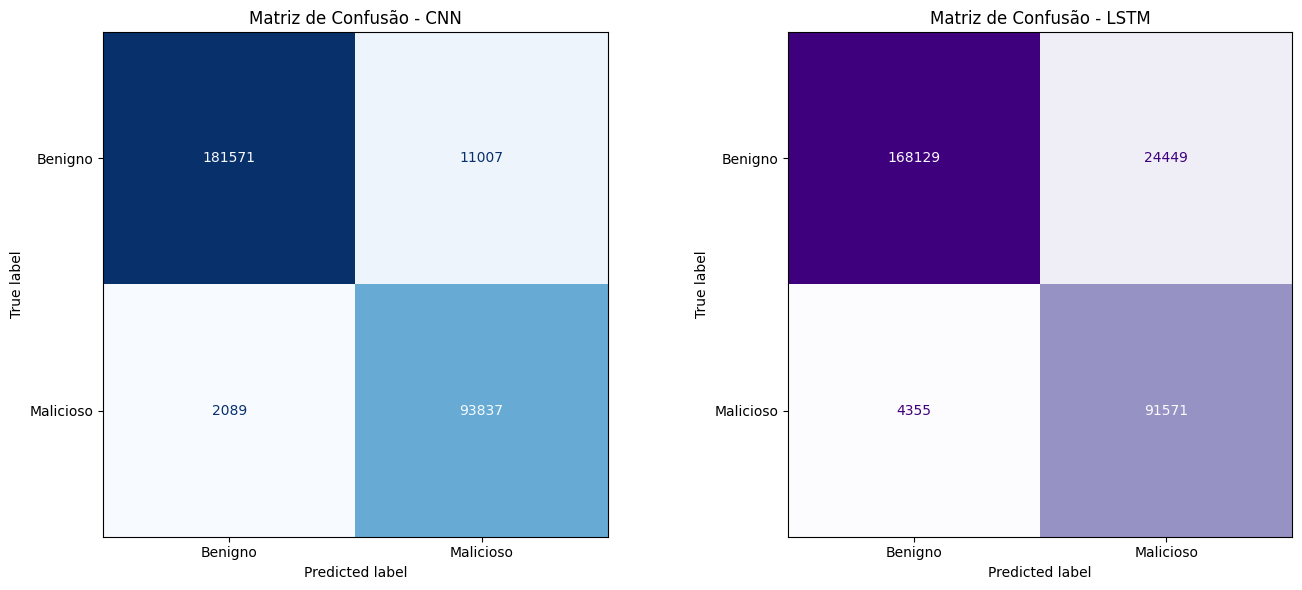

In [23]:
# 2. Função para binarizar (Transformar 4 classes em 2)
def to_binary(arr):
    return (arr != BENIGN_IDX).astype(int)

# Converter Reais e Preditos
y_pred_cnn_bin = to_binary(y_pred_cnn)
y_pred_lstm_bin = to_binary(y_pred_lstm)

# 3. Plotar
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# CNN
cm_cnn = confusion_matrix(y_test_binary, y_pred_cnn_bin)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=['Benigno', 'Malicioso'])
disp_cnn.plot(ax=axes[0], cmap='Blues', colorbar=False, values_format='d')
axes[0].set_title('Matriz de Confusão - CNN')

# LSTM
cm_lstm = confusion_matrix(y_test_binary, y_pred_lstm_bin)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['Benigno', 'Malicioso'])
disp_lstm.plot(ax=axes[1], cmap='Purples', colorbar=False, values_format='d')
axes[1].set_title('Matriz de Confusão - LSTM')

plt.tight_layout()
plt.show()

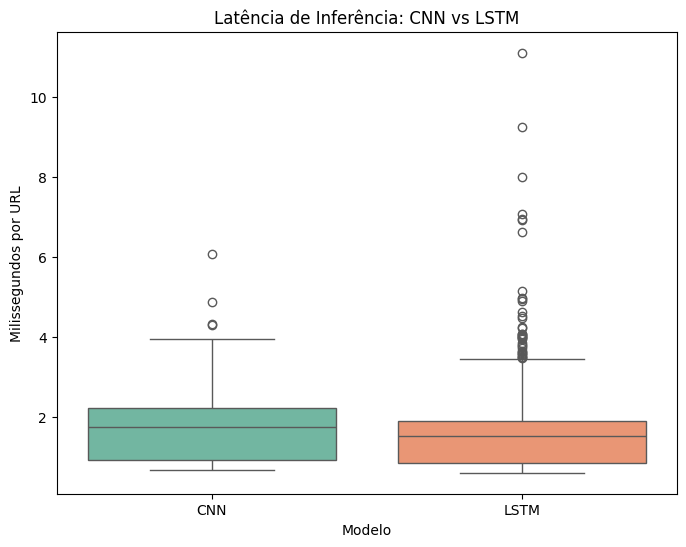

In [28]:
# Função para medir tempo
def measure_inference(model, data, n_loops=1000):
    times = []
    # Pega uma amostra única para testar repetidamente
    sample = data[0].unsqueeze(0).to(device)
    with torch.no_grad():
        for _ in range(n_loops):
            start = time.time()
            _ = model(sample)
            times.append((time.time() - start) * 1000) # ms
    return times

times_cnn = measure_inference(model_cnn, test_dataset.X)
times_lstm = measure_inference(model_lstm, test_dataset.X)

# Criar DataFrame para plotar
df_time = pd.DataFrame({
    'Tempo (ms)': times_cnn + times_lstm,
    'Modelo': ['CNN']*1000 + ['LSTM']*1000
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Modelo', y='Tempo (ms)', data=df_time, palette="Set2", hue='Modelo', legend=False)
plt.title('Latência de Inferência: CNN vs LSTM')
plt.ylabel('Milissegundos por URL')
plt.show()

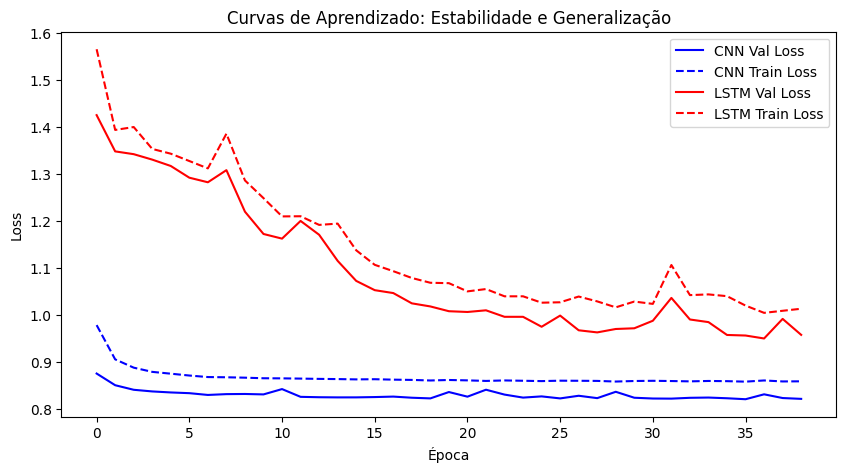

In [32]:
# Supondo que você tenha os históricos salvos (ex: history_cnn, history_lstm)
plt.figure(figsize=(10, 5))

# CNN
plt.plot(history_cnn['val_loss'], label='CNN Val Loss', color='blue')
plt.plot(history_cnn['train_loss'], label='CNN Train Loss', color='blue', linestyle='--')

# LSTM
plt.plot(history_lstm['val_loss'], label='LSTM Val Loss', color='red')
plt.plot(history_lstm['train_loss'], label='LSTM Train Loss', color='red', linestyle='--')

plt.title('Curvas de Aprendizado: Estabilidade e Generalização')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

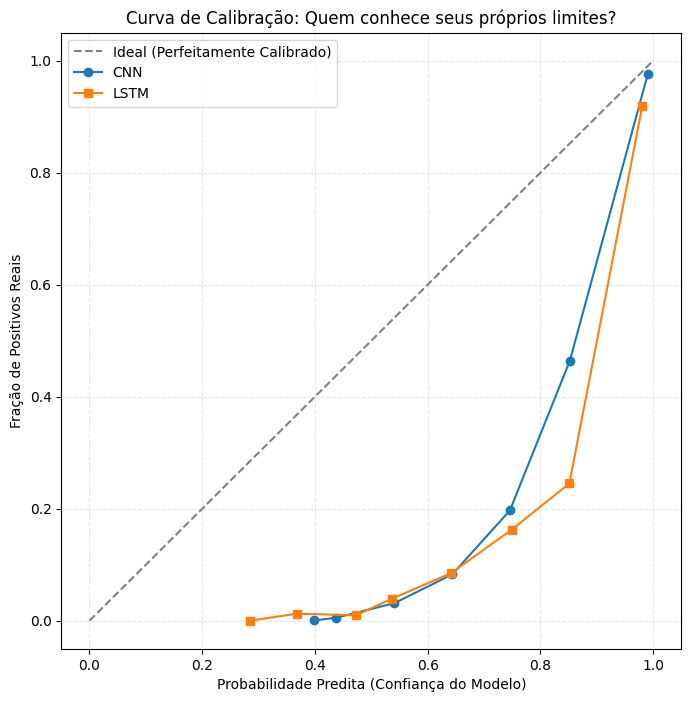

In [34]:
# 1. Definir a probabilidade da classe POSITIVA (Malicioso)
# P(Malicioso) = 1.0 - P(Benigno)
y_probs_cnn_pos = 1.0 - y_probs_cnn[:, BENIGN_IDX]
y_probs_lstm_pos = 1.0 - y_probs_lstm[:, BENIGN_IDX]

# 2. Calcular curvas de calibração
# Note que passamos 'y_test_binary' (gabarito 0 ou 1) e 'y_probs_..._pos' (probabilidade float 0.0 a 1.0)
prob_true_cnn, prob_pred_cnn = calibration_curve(y_test_binary, y_probs_cnn_pos, n_bins=10)
prob_true_lstm, prob_pred_lstm = calibration_curve(y_test_binary, y_probs_lstm_pos, n_bins=10)

# 3. Plotar
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal (Perfeitamente Calibrado)', color='gray')

# Plotar CNN
plt.plot(prob_pred_cnn, prob_true_cnn, marker='o', label='CNN')

# Plotar LSTM
plt.plot(prob_pred_lstm, prob_true_lstm, marker='s', label='LSTM')

plt.xlabel('Probabilidade Predita (Confiança do Modelo)')
plt.ylabel('Fração de Positivos Reais')
plt.title('Curva de Calibração: Quem conhece seus próprios limites?')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()